In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load & combine datasets

df_train = pd.read_csv("/content/UNSW_NB15_training-set.csv")
df_test  = pd.read_csv("/content/UNSW_NB15_testing-set.csv")

df_train = df_train.dropna(subset=['label']).dropna()
df_test  = df_test.dropna(subset=['label']).dropna()

df_train['label'] = df_train['label'].astype(int)
df_test['label']  = df_test['label'].astype(int)

df_combined = pd.concat([df_train, df_test], ignore_index=True)
num_records_total = len(df_combined)

# Columns

categorical_cols = ['proto', 'service', 'state', 'swin', 'dwin',
                    'trans_depth', 'ct_flw_http_mthd', 'is_ftp_login',
                    'ct_ftp_cmd', 'is_sm_ips_ports']
numerical_cols = [c for c in df_combined.columns
                  if c not in categorical_cols + ['id', 'attack_cat', 'label']]
feature_cols = categorical_cols + numerical_cols

# Encode categorical & scale numerical

le_dict = {}
for c in categorical_cols:
    le = LabelEncoder()
    df_combined[c] = le.fit_transform(df_combined[c].astype(str))
    le_dict[c] = le

scaler = MinMaxScaler()
df_combined[numerical_cols] = scaler.fit_transform(df_combined[numerical_cols])

# Node features

record_x = torch.tensor(df_combined[feature_cols].values, dtype=torch.float)

# Hub nodes & edges

edges = []
hub_features = []
hub_id_map = {}
src_ip_col, dst_ip_col = 'ct_src_ltm', 'ct_dst_ltm'

def add_hub_edges(ip_series, prefix, offset=0):
    for ip in ip_series.unique():
        hub_idx = num_records_total + len(hub_id_map) + offset
        hub_id_map[(prefix, ip)] = hub_idx
        rec_indices = df_combined[df_combined[ip_series.name] == ip].index.tolist()
        for rec_idx in rec_indices:
            edges.append([rec_idx, hub_idx])
            edges.append([hub_idx, rec_idx])
        hub_features.append(torch.zeros(record_x.shape[1]))

add_hub_edges(df_combined[src_ip_col], 'src')
add_hub_edges(df_combined[dst_ip_col], 'dst')

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
hub_x = torch.stack(hub_features, dim=0)
node_features = torch.cat([record_x, hub_x], dim=0)

# Labels

y_record = torch.tensor(df_combined['label'].values, dtype=torch.long)
y_hub = torch.full((len(hub_features),), -1, dtype=torch.long)
y = torch.cat([y_record, y_hub])

# Masks

train_mask = torch.zeros(num_records_total + len(hub_features), dtype=torch.bool)
test_mask  = torch.zeros(num_records_total + len(hub_features), dtype=torch.bool)

train_idx, test_idx = train_test_split(range(len(df_train)),
                                       test_size=0.2,
                                       stratify=df_train['label'],
                                       random_state=42)

train_mask[train_idx] = True
test_mask[len(df_train):] = True

data = Data(x=node_features, edge_index=edge_index, y=y,
            train_mask=train_mask, test_mask=test_mask)

# GraphSAGE model

class DeeperGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        return self.conv4(x, edge_index)

model = DeeperGraphSAGE(node_features.shape[1], 64, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Train

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluate on test set

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

# Filter out hub nodes

mask = data.test_mask & (data.y != -1)
y_true_test = y[mask].cpu().numpy()
y_pred_test = pred[mask].cpu().numpy()

print("Test Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("\nTest Classification Report:\n", classification_report(y_true_test, y_pred_test))


Epoch 10, Loss: 1.0027
Epoch 20, Loss: 0.6202
Epoch 30, Loss: 0.6131
Epoch 40, Loss: 0.5684
Epoch 50, Loss: 0.5080
Epoch 60, Loss: 0.4004
Epoch 70, Loss: 0.2865
Epoch 80, Loss: 0.2565
Epoch 90, Loss: 0.2468
Epoch 100, Loss: 0.2186
Epoch 110, Loss: 0.2010
Epoch 120, Loss: 0.1901
Epoch 130, Loss: 0.1828
Epoch 140, Loss: 0.1780
Epoch 150, Loss: 0.1748
Epoch 160, Loss: 0.1723
Epoch 170, Loss: 0.3391
Epoch 180, Loss: 0.4652
Epoch 190, Loss: 0.4097
Epoch 200, Loss: 0.2938
Epoch 210, Loss: 0.2597
Epoch 220, Loss: 0.2300
Epoch 230, Loss: 0.2150
Epoch 240, Loss: 0.2053
Epoch 250, Loss: 0.1980
Epoch 260, Loss: 0.1918
Epoch 270, Loss: 0.2085
Epoch 280, Loss: 0.1840
Epoch 290, Loss: 0.1792
Epoch 300, Loss: 0.1741
Epoch 310, Loss: 0.1721
Epoch 320, Loss: 0.1703
Epoch 330, Loss: 0.1687
Epoch 340, Loss: 0.1673
Epoch 350, Loss: 0.1658
Epoch 360, Loss: 0.1645
Epoch 370, Loss: 0.1633
Epoch 380, Loss: 0.1698
Epoch 390, Loss: 0.1696
Epoch 400, Loss: 0.1931
Epoch 410, Loss: 0.1720
Epoch 420, Loss: 0.1650
E

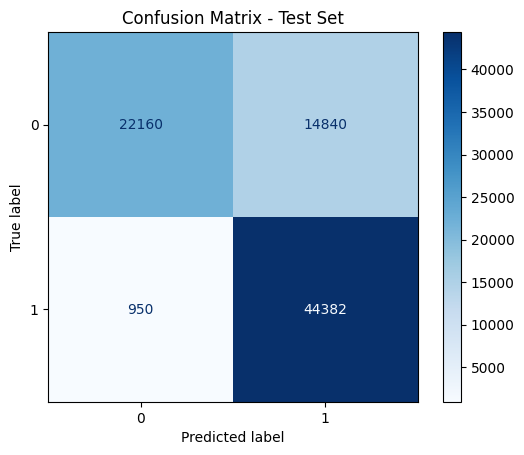

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

